## Example: Optimizing a 3D Printed Material for Strength Under Constraints

Imagine you are given the task of optimizing the parameters of a 3D printer to maximize the strength of a printed part. You believe Bayesian optimization can help you in this task and decide to put together a simple optimization script using Honegumi. 

Looking at the printer's settings, you see that the following parameters can be adjusted within the specified bounds:

| | **Parameter Name** | **Bounds**                              |
|------|--------------------|-----------------------------------------|
| x1   | X Offset           | [-1.0, 1.0]                                 |
| x2   | Y Offset           | [-1.0, 1.0]                                 |
| x3   | Infill Density     | [0.0, 1.0]                                  |
| x4   | Layer Height       | [0.0, 1.0]                                  |
| c1   | Infill Type        | [honeycomb, gyroid, lines, rectilinear] |

In addition to tight time constraints (number of optimization trials $\le$ 30), your manager tells you that the cost of printing the part cannot exceed $13. The print cost can be computed as a function of the `infill density` and `layer height` using the following linear equation: `cost = $16.32 * infill_density - $3.73 * layer_height`

A dummy objective function has been constructed in the code cell below to emulate the results of experimental trials under different inputs. Although we can easily find the optimal value using the equation, we will pretend that the objective function is unknown and use a Bayesian optimization approach to find the optimal set of input parameters instead.

In [116]:
import numpy as np

def printed_strength(x1, x2, x3, x4, c1):
    """
    Calculates the printed strength based on the given input parameters.

    Parameters:
    x1 (float): x_offset [-1.0, 1.0].
    x2 (float): y_offset [-1.0, 1.0].
    x3 (float): infill_density [0.0, 1.0].
    x4 (float): layer_height [0.0, 1.0].
    c1 (str): The type of infill type ["honeycomb", "gyroid", "lines", "rectilinear"].

    Returns:
    float: The calculated printed strength.
    """
    y = float(
        20*(x1**2*np.sin(x1/2)+1) +
        10*(x2*np.cos(x2*0.5-1.5)+1) +
        5*(np.log(x3) + 10) +
        3*(1 / (0.25 * np.sqrt(2 * np.pi))) * np.exp(-(x4 - 0.23)**2 / (2 * 0.25**2)) - 
        1.3*x4+10
    )

    infill_effects = {
        'honeycomb': 1,
        'gyroid': 1.5,
        'lines': 0.5,
        'rectilinear': 0.8
    }

    y *= infill_effects[c1]

    return y

## Applying Honegumi

We will now use the [Honegumi website](https://honegumi.readthedocs.io/en/latest/) to generate a script that will help us optimize the printer parameters. From the description, we observe that our problem is a **single objective** optimization problem with an added **categorical variable** input and a **linear constraint** on the cost. To create an optimization script for this problem, we select the following options:

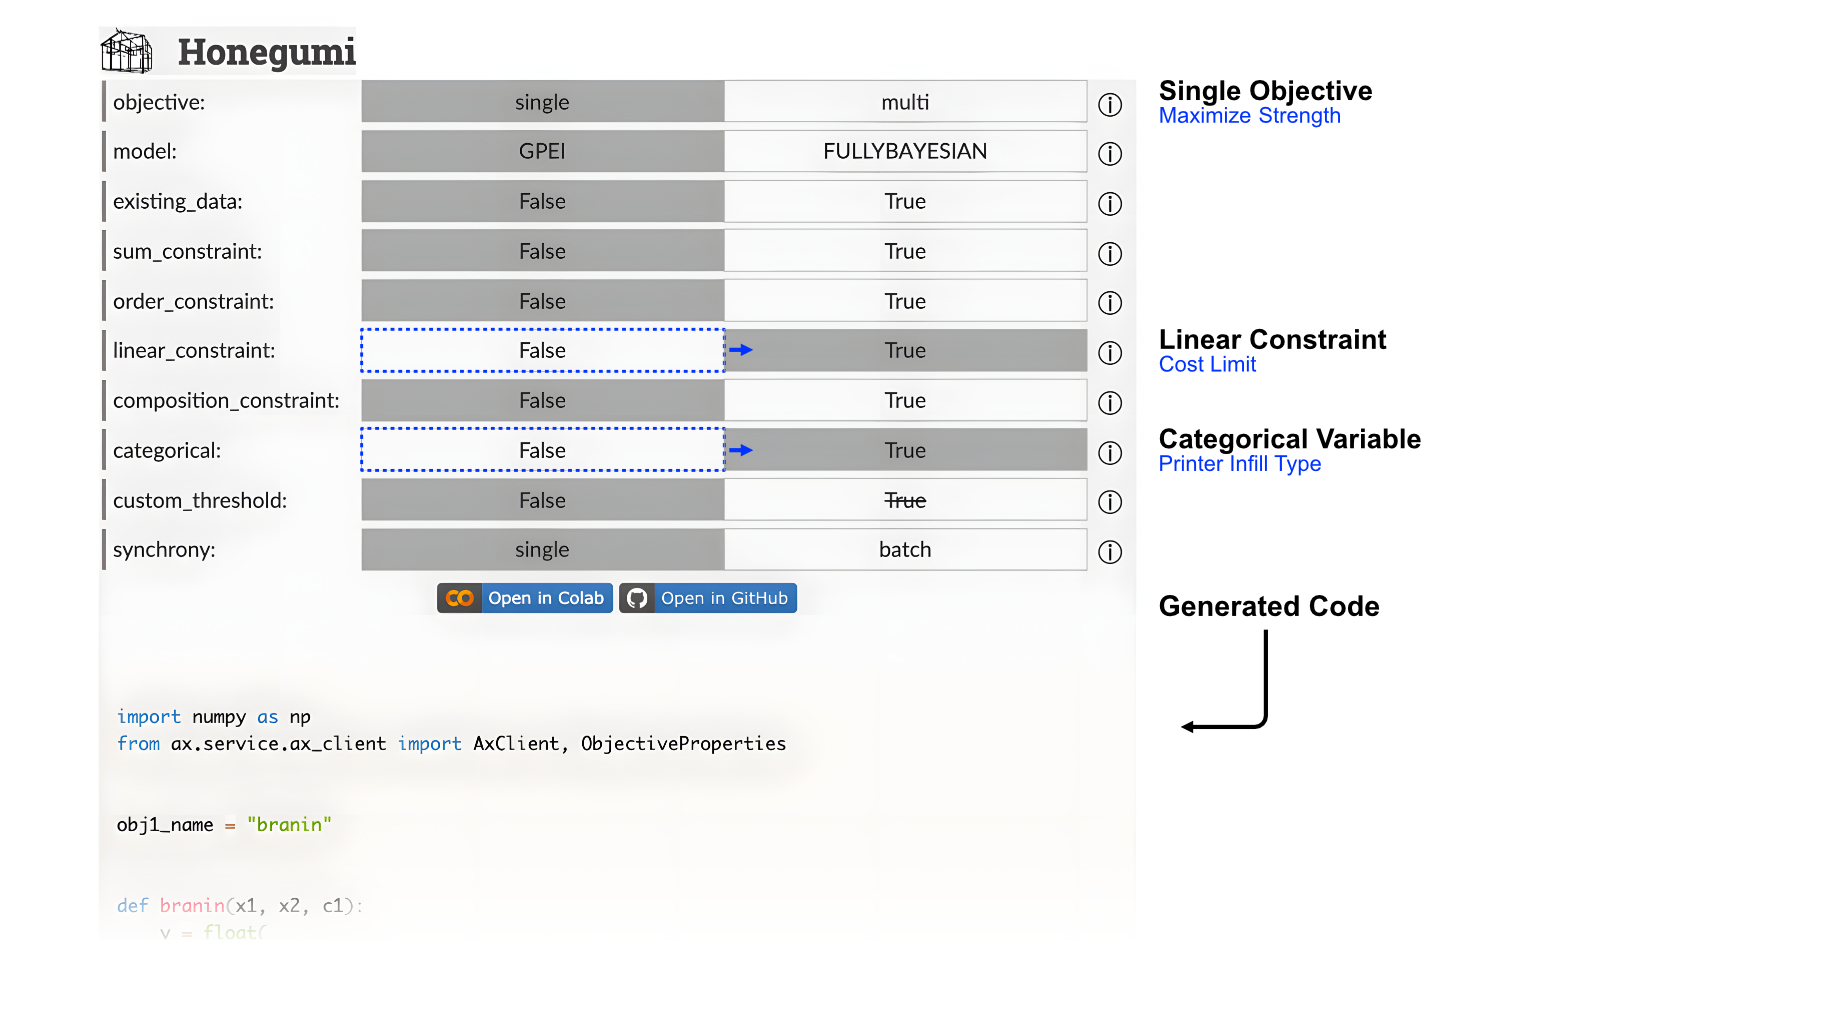

The Honegumi generated optimization script will provide a framework for our optimization campaign that we can modify to suit our specific problem needs. In the code sections below, we will make several modifications to this generated script to make it compatible with our problem.

## Modifying the Code for Our Problem

We can modify this code to suit our problem with a few simple modifications. Wherever a modification has been made to the code, a comment starting with `# CHANGE:` has been added along with a brief description of the change.

In [117]:
from ax.service.ax_client import AxClient, ObjectiveProperties

ax_client = AxClient(random_seed=125) # CHANGE: add a random seed for repeatability

obj1_name = "printed_strength" # CHANGE: adjust the objective name to match our function

# CHANGE: Remove the branin dummy objective function, we will use the printer function

ax_client.create_experiment(
    parameters=[
        {"name": "x1", "type": "range", "bounds": [-1.0, 1.0]}, # CHANGE: update parameter
        {"name": "x2", "type": "range", "bounds": [-1.0, 1.0]}, # CHANGE: update parameter
        {"name": "x3", "type": "range", "bounds": [0.0, 1.0]}, # CHANGE: add new parameter
        {"name": "x4", "type": "range", "bounds": [0.0, 1.0]}, # CHANGE: add new parameter
        {
            "name": "c1", 
            "type": "choice", 
            "is_ordered": False, 
            "values": ["honeycomb", "gyroid", "lines", "rectilinear"] # CHANGE: add categories
            
        },
    ],
    parameter_constraints=[
        "16.32*x3 - 3.73*x4 <= 13.0", # CHANGE: input the linear printer cost constraint
    ],
    objectives={
        obj1_name: ObjectiveProperties(minimize=False), # CHANGE: set minimize = FALSE
    },
)

for _ in range(30): # CHANGE: this is a tough problem, increase number of trials

    parameterization, trial_index = ax_client.get_next_trial()

    # CHANGE: pull all added parameters from the parameterization
    x1 = parameterization["x1"]
    x2 = parameterization["x2"]
    x3 = parameterization["x3"]
    x4 = parameterization["x4"]
    c1 = parameterization["c1"]

    results = printed_strength(x1, x2, x3, x4, c1) # CHANGE: switch to printer function
    ax_client.complete_trial(trial_index=trial_index, raw_data=results)

best_parameters, metrics = ax_client.get_best_parameters()

[INFO 04-08 11:22:31] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[WARNING 04-08 11:22:31] ax.service.ax_client: Random seed set to 125. Note that this setting only affects the Sobol quasi-random generator and BoTorch-powered Bayesian optimization models. For the latter models, setting random seed to the same number for two optimizations will make the generated trials similar, but not exactly the same, and over time the trials will diverge more.
[INFO 04-08 11:22:31] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x1. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-08 11:22:31] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x2. If that is not the expected va

### Show the Best Parameters

After our optimization loop has completed, we can use the model to find the best parameters and their corresponding strength value. These will be our optimial set of parameters that we use in the 3D printer going forward.

In [123]:
ax_client.get_best_trial()

[INFO 04-08 11:30:14] ax.modelbridge.base: Leaving out out-of-design observations for arms: 22_0


(29,
 {'x1': 0.25158306589474977,
  'x2': -1.0,
  'x3': 0.8609995465769321,
  'x4': 0.2909716038647014,
  'c1': 'gyroid'},
 ({'printed_strength': 146.70775284531527},
  {'printed_strength': {'printed_strength': 0.09174820515491967}}))

### Plotting Optimization Performance

We can plot the performance of our optmization loop to see how the optimization task progressed as a function of iteration count.

We observe that our initial sobol trials were were extremely helpful in finding a good starting region for the gaussian process model.

In [124]:
from ax.utils.notebook.plotting import init_notebook_plotting, render

render(ax_client.get_optimization_trace())

### Assessing Model Accuracy

We can also assess the accuracy of our model by comparing the predicted strength values to the actual strength values. This can help us understand how well our model is performing and how trusting we can be of the optimal parameters it suggests.

In [125]:
from ax.modelbridge.cross_validation import cross_validate
from ax.plot.diagnostic import interact_cross_validation

model = ax_client.generation_strategy.model
cv_results = cross_validate(model)
render(interact_cross_validation(cv_results))